## Vector analysis using Affine2D()

from matplotlib.trasnforms import Affine2D

    . ax.transData            --- from virtual coordinates to normal data coordinates
    . ax.transAxes            --- from virtual coordinates to axes-relative (0 - 1) coordinates
    . ax.transFigure          --- from virtual coordinates to figure-relative (0 - 1)
    . ax.transDta.inverted()  --- from virtual coordinates to convert from display back to data

### Transform data coordinates to display (pixel) coordinates

xdata, ydata = 1.2, 0.7
xdisp, ydisp = ax.transData.transform((xdata, ydata))

### Transform diplay (pixel) coordinates back to data coordinates

xdata2, ydata2 = ax.transData.inverted().transform((xdisp, ydisp))

### Round trip

assert (xdata, ydata) == (xdata2, ydata2)

Affine2D().scale(sx, sy)
Affine2D().rotate(theta)
Affine2D().rotate_deg(deg)
Affine2D().shear(shx, shy)
Affine2D().skew_deg(shx, shy)
Affine2D().translate(tx, ty)

### Concatenate transforms using the dot

rotations, scaling, translation etc.

T = Affine2D().rotate(alpha).scale(sx, sy).translate(tx, ty)

### Use method transform to apply the transform to data coordinates in figure

ax.transData yields pixel coordinates of the screen, seldom interesting for the user.

T = T + ax.transData
xy_new = T.transform(xy_old)

In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib import patches
from itertools import cycle

In [56]:
# --- Affine2D has a 41 usable attributes
# [p for p in dir(Affine2D) if not p.startswith('_')]

In [57]:
# help(Affine2D().translate)
# help(Affine2D().transform)

In [58]:

def arrow(xy, dxy, ax=None, transform=None, **kwargs):
    """
    Draw a proper arrow with optional affine transform.
    Keeps arrow head size stable and updates axes limits.
    
    The orignal arrow method is not always stable, so annotate
    is wrapped to provide a stable angle.

    
    Usage
    -----
    fig, ax = plt.subplots()
    for angle in np.linspace(0, 330, 11):
        t = Affine2D().rotate_deg(angle) # + ax.transData
        arrow((1, 1), (2, 0.5), ax=ax, transform=t, color="C0", lw=2)

plt.show()

    """
    ax = ax or plt.gca()
    
    xy  = np.atleast_1d( xy)
    dxy = np.atleast_1d(dxy)

    # --- Base geometry as 2x2 array
    pts = np.array([xy, xy + dxy])

    # --- If a transform is provided, apply it to the data
    if transform is not None:
        pts = transform.transform(pts)

    # --- Autoscale axes to include arrow
    ax.update_datalim(pts)
    ax.autoscale_view()

    p0, p1 = pts

    return ax.annotate(
        "",
        xy=p1,
        xytext=p0,
        arrowprops=dict(
            arrowstyle="-|>",   # fixed-size arrow head
            shrinkA=0,
            shrinkB=0,
            linewidth=1.0,
            **kwargs
        )
    )


def perpendicular_vector(P, A, B):
    """Return vector d perpendicular to line through points A and B and hitted point F."""
    P = np.asarray(P)
    A = np.asarray(A)
    B = np.asarray(B)

    v = B - A               # line direction
    w = P - A

    t = np.dot(w, v) / np.dot(v, v)
    F = A + t * v           # foot point
    d = F - P               # perpendicular vector (from P to line)

    return d, F


## Example of use of Affine2D

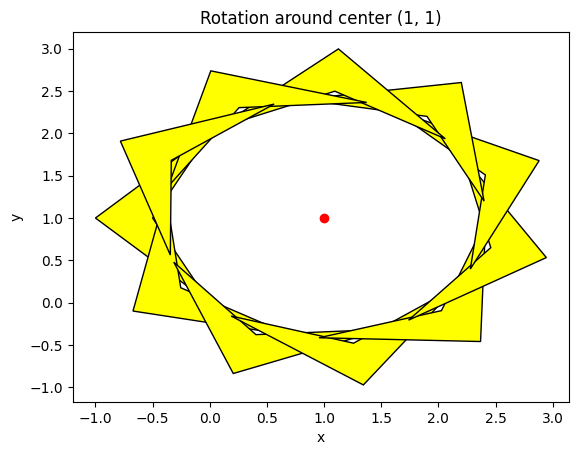

In [59]:
def shift(dx, dy):
    """Return an affine translation"""
    return Affine2D().translate(dx, dy)

def rotation_around_center(angle, center=(0, 0)):
    """Return an Affine2D rotation around an arbitrary point."""
    cx, cy = center
    return (Affine2D()
            .translate(-cx, -cy)
            .rotate_deg(angle)
            .translate(cx, cy))


fig, ax = plt.subplots()

xy = np.array([[0., 0.], [-1., 1.], [0, 2] ,[-0.5, 1] ,[0, 0]])
center = (1, 1)
ax.set(title=f"Rotation around center ({center[0]}, {center[1]})", xlabel='x', ylabel='y')
ax.plot(*center, 'ro')
for angle in np.linspace(0, 333, 11):
    rot = rotation_around_center(angle, center=center)
    p = patches.Polygon(xy, fc='yellow', ec='black')
    p.set_transform(rot + ax.transData)
    ax.add_patch(p)

ax.autoscale()

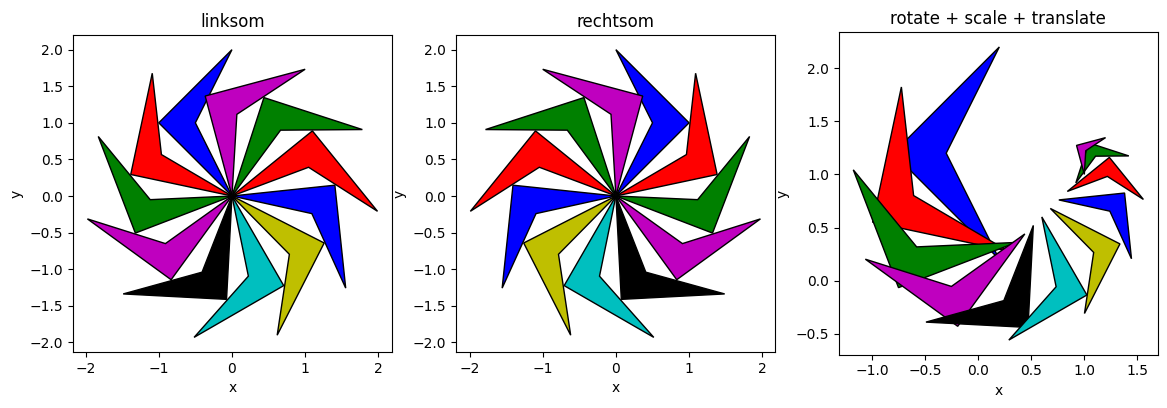

In [60]:
def update_datalim(patch, ax):
    """Update the ax.datalim for autoscaling."""
    path = patch.get_path()
    trans = patch.get_patch_transform()
    verts = trans.transform(path.vertices)
    ax.update_datalim(verts)

# --- shape (sikkel)
xyR = np.array([[0., 0.], [1., 1.], [0, 2] ,[0.5, 1] ,[0, 0]])
xyL = np.array([[0., 0.], [-1., 1.], [0, 2] ,[-0.5, 1] ,[0, 0]])

# --- show it
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(14, 7))

ax1.set(title='linksom',  xlabel='x', ylabel='y')
ax2.set(title='rechtsom', xlabel='x', ylabel='y')
ax3.set(title='rotate + scale + translate', xlabel='x', ylabel='y')

# ax1.plot(*xyL.T)
# ax2.plot(*xyR.T)
# ax3.plot(*xyL.T)

# --- rotate it
clrs = cycle('brgmkcy')
for alpha, s, t in zip(np.linspace(0, 330, 11), np.linspace(1, 0.2, 11), np.linspace(0.2, 1, 11)):
    clr = next(clrs)
    
    # --- rotate clockwise
    trL = Affine2D().rotate_deg(alpha)
    pL = patches.Polygon(xyL, fc=clr, ec='black')
    pL.set_transform(trL + ax1.transData)
    
    # --- rotate anti-clockwise
    trR = Affine2D().rotate_deg(-alpha)
    pR = patches.Polygon(xyR, fc=clr, ec='black')
    pR.set_transform(trR + ax2.transData)
    
    # --- rotate, scale and translate
    tr = Affine2D().rotate_deg(alpha).scale(s, s).translate(t, t)
    p = patches.Polygon(xyL, fc=clr, ec='black')
    p.set_transform(tr + ax3.transData)
    
    # --- update datalim of the axes
    update_datalim(pL, ax1)
    update_datalim(pR, ax2)
    update_datalim(p,  ax3)

    # --- add the patches
    ax1.add_patch(pL)
    ax2.add_patch(pR)
    ax3.add_patch(p)
        
# --- apply autoscale, without it the xlim and ylim are still 0-1
ax1.autoscale_view()
ax2.autoscale_view()
ax3.autoscale_view()
    
# --- keep axes the same
ax1.set_aspect(1.0)
ax2.set_aspect(1.0)
ax3.set_aspect(1.0)

fig.savefig(os.path.join(os.getcwd(), '../images', 'test_affine.png'))


## Example groundwater anisotropy

Anisotropic case in 2D of a well near a canal, where the main conductivity axes make an angle of 40 deg with the map axes. The first image is the map, the second shows the map rotated to align with the horizontal and vertical axes (new map, say).The third image shows the scaling such that the conductivities become the same in both direction and the problem will be isotropic. The coordinates of the mirror well are computed to place this mirror well. The drawdown by well and  mirror well are computed on a grid in the istropic map. Then the contours of the drawdown are computed. Back-transformation of uses the coordinates of the contours, obtained from Cs.get_paths(). It also uses their level form Cs.levels and their edgecolors form cs.edgecolor or cs.ec. Transforms these back to the seond and then to the first image and plots them using the same colors as the original isotropic contour lines in image #3.

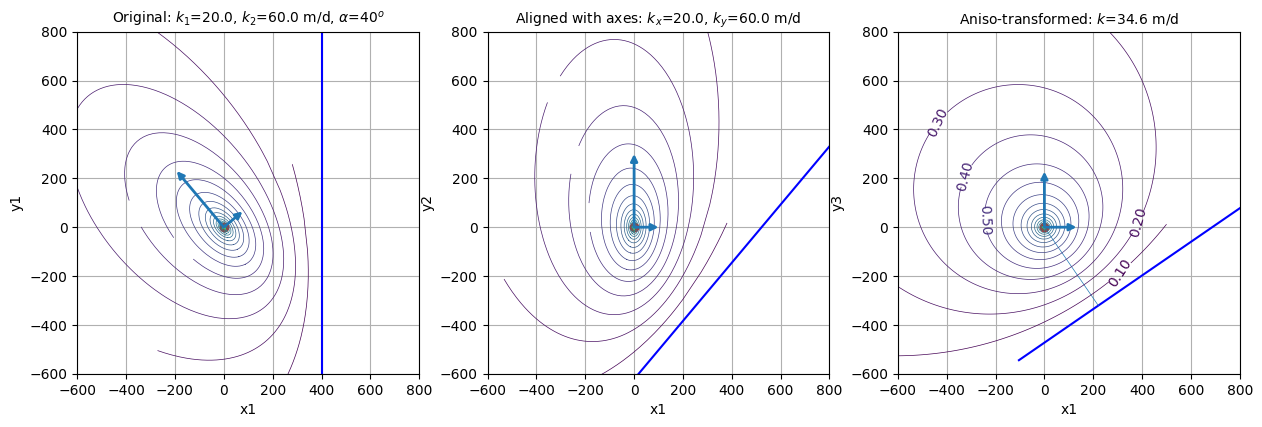

In [61]:
well = np.array([0., 0.])
shore = np.array([[400, -600], [400, 800]])
alpha = 40
kx, ky = 20., 60.
D, rw = 30., 0.25
k = np.sqrt(kx * ky)

# --- define arrows lenghts do denote the axes direction
xax = np.array([[0, 0],[1, 0]]) * kx * 5
yax = np.array([[0, 0],[0, 1]]) * ky * 5

# --- Align with the anisotropy's main conductivity axes
xax = Affine2D().rotate_deg(alpha).transform(xax)
yax = Affine2D().rotate_deg(alpha).transform(yax)


# --- Plot three consequtive axes to show original, rotated and stretched situations
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

# --- Loop over the three axes concatenating rotation and scaling using three sets of parameters
for i, (ax, angle, (kx_, ky_), title, xlabel, ylabel) in enumerate(zip((ax1, ax2, ax3),
                                              (0, alpha, alpha),
                                              ((1, 1), (1, 1), (kx, ky)),
                                              (fr"Original: $k_1$={kx}, $k_2$={ky} m/d, $\alpha$={alpha}$^o$",
                                               fr"Aligned with axes: $k_x$={kx}, $k_y$={ky} m/d",
                                               fr"Aniso-transformed: $k$={k:.1f} m/d"
                                               ),
                                              ('x1', "x1", "x1"),
                                              ('y1', "y2", "y3"),
                                              )):
    k_ = np.sqrt(kx_ * ky_)
    
    # ---  Affine transformation without ax.transData
    tr = Affine2D().rotate_deg(-angle).scale(np.sqrt(k_ / kx_), np.sqrt(k_ /ky_))
        
    ax.set_title(title,   fontsize=10)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    
    ax.grid(True)

    ax.plot(*well,    'ro', transform=tr + ax.transData)
    ax.plot(*shore.T, 'b-', transform=tr + ax.transData)
    
    
    # ax.plot(*xax.T, 'r',    transform=tr + ax.transData)
    # ax.plot(*yax.T, 'g',    transform=tr + ax.transData)
    
    # --- The axes arrows without ax.transData
    arrow(xax[0], xax[1], ax=ax, transform=tr, color="C0", lw=2)
    arrow(yax[0], yax[1], ax=ax, transform=tr, color="C0", lw=2)
        
    ax.set_aspect(1.)
    ax.set_xlim(-600, 800)
    ax.set_ylim(-600, 800)

# --- Point perpendicular to the shore line in the isotropic situation
k =np.sqrt(kx_* ky_)
shore_iso = Affine2D().rotate_deg(-alpha).scale(np.sqrt(k / kx), np.sqrt(k /ky)).transform(shore)
d, F = perpendicular_vector(well, *shore_iso)

# --- plot the line from the well to the point perpendicular to the shore
ax3.plot(*np.vstack((well, F)).T, lw=0.5)

# --- In the isotropic axes construct the drawdown and the contour lines
Q, kD = 2400, k_ * D
P1 = (0, 0)
well_mirror = well + 2 * d

# --- Points to compute the drawdown
x = np.linspace(-700, 500, 121)
y = np.linspace(-600, 800, 141)
X, Y = np.meshgrid(x, y)

# --- Distance from these grid points to the wells
r1 = np.fmax(np.sqrt((X - well[       0]) ** 2 + (Y - well[       1]) ** 2), rw)
r2 = np.fmax(np.sqrt((X - well_mirror[0]) ** 2 + (Y - well_mirror[1]) ** 2), rw)

# --- The drawdown
s = Q / (2 * np.pi * kD) * np.log(r2 / r1)

# --- Contour the drawdown
levels = np.linspace(0, 3, 31)[1:]
Cs = ax3.contour(X, Y, s, levels=levels, linewidths=0.5)
ax3.clabel(Cs, levels=Cs.levels[:5], fmt='%.2f')

# --- Plot the drawdown on the previous axes through back-transformations
for path, level , ec in zip(Cs.get_paths(), Cs.levels, Cs.get_ec()):          # each level
    v = path.vertices                  # (n, 2) array of points
    if len(v) > 0:
        v2 = Affine2D().scale(np.sqrt(kx / k), np.sqrt(ky / k)).transform(v)
        ax2.plot(*v2.T, color=ec, lw=0.5)
        
        v3 = Affine2D().rotate_deg(alpha).transform(v2)
        ax1.plot(*v3.T, color=ec, lw=0.5)

os.path.isdir(os.path.join(os.getcwd(), 'images'))
fig.savefig(os.path.join(os.getcwd(), '../images', 'anisotropy.png'))

In [62]:
os.getcwd()

'/Users/Theo/GRWMODELS/python/tools/coords/notebooks'